In [6]:
# --- MATS causal interventions + hydra-style analysis (Llama-3.2-3B) ---

import os, math, json, random, gc, pathlib
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Literal

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

SEED = 123
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)



# Evaluation settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16
HF_TOKEN   = os.environ.get("HF_TOKEN")
GEN_MAX_NEW_TOKENS = 64
TEMPERATURE = 0.0
TOP_K = None

# Anchor positions we evaluate hydra/kl at:
EVAL_POS = "last"   # 'last' or 'first_code' (we compute first code token index)



In [7]:

# Examples of what token set type is used
# token_list_value = {
#     "cpp_top": ["std", "int", ";", "{", "}", "[i", "long", "return", "<<", ">>"],
#     "python_top": [":", "None", "def", "print", "==", "len", "range", "str", ",", "):"],
#     "science": ["energy", "water", "cells", "system", "body", "blod", "carbon", "molecules", "light", "atoms"],
#     "medical": ["cause", "options", "clinical", "patient", "blood", "symptoms", "disease", "diagnosis", "pain", "condition"],
#     "finance": ["company", "total", "capital", "share", "tax", "assets", "total", "rate", "ratio", "value"],
#     "math": ["total", "many", "number", "per", "cost", "times", "find", "one", "amount", "money"]
# }
def tok(s: str):
    return tokenizer(s, return_tensors="pt").to(DEVICE)

def untok(s: int):
    return tokenizer.decode(s)
# [tok(i)['input_ids'][0][1].item() for i in config_dict['cpp-python'].a.token_set]
# token_list = {key: [tok(i)['input_ids'][0][1].item() for i in value] for key, value in token_list_value.items()}

# print(token_list) 
class Language:
    def __init__(self, name: str, token_set: list[str] | None = None):
        self.name = name
        if token_set is None:
            self.token_set = self.load_tokens()
        else:
            self.token_set = token_set
        
    def load_tokens(self):
        with open("token_sets/tokens.json", 'r') as f:
            data = json.load(f)
            
        if self.name == "cpp_top":
            print(data["cpp_top"])
            return data["cpp_top"]
        if self.name == "python_top":
            print(data["python_top"])
            return data["python_top"]
        return data[self.name]
    # def load_specific(self):
    #     return token_list[self.name]

class DatasetPairConfig:
    def __init__(self, lang_a: str, lang_b: str, file_path: str):
        self.a = Language(lang_a)
        self.b = Language(lang_b)
        self.prompts = self.load_file(file_path)
        
    def load_file(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        prompts = []
        for element in data:
            prompts.append((element[self.a.name], element[self.b.name]))
        return prompts
        
        
# CPP_TOKENS = {"def", "import", ":", "pass"}     # Python-ish indicators
# PYTHON_TOKENS = {";", "::", "std", "#"}            # C++-ish indicators; '#' approximates #include

config_dict = {
    "cpp-python": DatasetPairConfig("cpp_top", "python_top", "prompt_set/cpp_python_add.json"),
    # "sci-math": DatasetPairConfig("science", "math", "prompt_set/sci_math_prompts.json"),
    # "medical-finance": DatasetPairConfig("medical", "finance", "prompt_set/fin_med_prompts.json"),
}
    

['cpp', 'c', ' def', ' c', ' //', ' #', 'python', ' public', 'def', 'public', 'C', 'java', ' class', ' C', 'class', ' import', 'import', '#', 'function', 'void', '//', 'bash', ' function', ' void', ' int', ' \n', ' const', ' cpp', ' python', '#include', ' ', 'include', ' Input', 'Write', 'const', ' Write', 'string', 'int', 'The', '$', ' string', 'from', 'bool', 'if', '@', ' from', ' char', 'private', '    ', 'Given', 'char', ' The', 'Python', ' /*', ' java', ' bool', ' @', ' $', 'var', '<|end_of_text|>', 'package', '  ', 'I', ' ```', '1', 'input', ' if', ' ```\n', 'javascript', ' Given', 'Input', 'find', ' private', 'Solution', 'In', ' input', ' *', 'n', '`\n', ' std', 'h', 'x', ' include', '<', 'std', '   ', 'sh', '{', ' In', 'js', ' Solution', ' https', ' var', 'https', '[', 'p', ' Find', 'This', ' Use', ' Python', 'k', ' A', 'sum', '*', 'array', ' <', ' I', 'ruby', 'for', ' n', 'Please', 'diff', 'using', ' Please', ' [', 'You', ' (', ' static', 'text', 'A', ' This', 'write', '(', 'C

In [8]:
# ---------------- Utilities ----------------
def tok(s: str):
    return tokenizer(s, return_tensors="pt").to(DEVICE)

def generate_logits(prompt: str, max_new_tokens=0):
    """Return logits over next token for the prompt (no generation if max_new_tokens=0)."""
    with torch.no_grad():
        enc = tok(prompt)
        out = model(**enc)
        logits = out.logits  # [B, T, V]
    return enc, logits

def pick_eval_index(tokenizer, input_ids: torch.Tensor, text: str, mode: str) -> int:
    # mode 'last': last token in the prompt; 'first_code': first token after a code marker
    if mode == "last":
        return input_ids.shape[1] - 1
    if mode == "first_code":
        # Heuristic: find "```" or a language marker in the prompt text
        idx = text.find("```")
        if idx < 0: return input_ids.shape[1] - 1
        # tokenize up to the backticks and use its length - 1
        prefix = text[:idx+3]
        with torch.no_grad():
            ids = tokenizer(prefix, return_tensors="pt").to(DEVICE)["input_ids"]
        return min(ids.shape[1]-1, input_ids.shape[1]-1)
    return input_ids.shape[1] - 1

def kl_divergence(p_logits, q_logits):
    # KL(p || q) at a single position; stable softmax
    p = F.log_softmax(p_logits, dim=-1)
    q = F.log_softmax(q_logits, dim=-1)
    return torch.sum(torch.exp(p) * (p - q), dim=-1)

def l2(x): return torch.norm(x.float(), dim=-1)

def token_prob_sum(logits, token_strs: List[str]) -> float:
    ids = []
    for s in token_strs:
        toks = tokenizer.encode(s, add_special_tokens=False)
        if len(toks) == 1:
            ids.append(toks[0])
    if not ids: return 0.0
    probs = F.softmax(logits, dim=-1)[..., ids]
    return probs.sum(-1).item()

# ---------------- Hooking helpers ----------------
@dataclass(frozen=True)
class LayerSpec:
    kind: Literal["attn","mlp"]
    idx: int

    
def get_layer_module(m: nn.Module, spec: LayerSpec) -> nn.Module:
    try:
        # Check for the multi-modal Gemma 3 structure first. This is more specific.
        if hasattr(m, 'model') and hasattr(m.model, 'language_model') and hasattr(m.model.language_model, 'layers'):
            layer = m.model.language_model.layers[spec.idx]
        # Fall back to the standard text-only transformer structure
        elif hasattr(m, 'model') and hasattr(m.model, 'layers'):
            layer = m.model.layers[spec.idx]
        else:
            # If neither structure is found, raise an error.
            raise AttributeError("Model does not have a recognizable '.model.layers' or '.model.language_model.layers' structure.")

        # Once the correct layer is found, access the specified module
        if spec.kind == "attn":
            return layer.self_attn
        elif spec.kind == "mlp":
            return layer.mlp
        else:
            raise ValueError(f"Invalid layer kind '{spec.kind}'. Must be 'attn' or 'mlp'.")
            
    except (AttributeError, IndexError) as e:
        # This provides a much clearer error message if the structure is wrong
        gemma3_path = f"model.language_model.layers[{spec.idx}]"
        llama_path = f"model.layers[{spec.idx}]"
        raise AttributeError(
            f"Could not access the specified layer in the model. "
            f"Tried paths for multi-modal Gemma ('{gemma3_path}') and standard Llama ('{llama_path}'), but failed. "
            f"Please double-check the model architecture. Original error: {e}"
        )

def _as_tensor(output):
    # Some HF modules may return tuple; we normalize to a tensor for replacement logic
    if isinstance(output, tuple):
        return output[0]
    return output

def _repack_like(original_output, new_tensor):
    # Put new_tensor back into the original structure if needed
    if isinstance(original_output, tuple):
        lst = list(original_output)
        lst[0] = new_tensor
        return tuple(lst)
    return new_tensor

class Capture:
    """Capture module outputs (pre-residual) at all sequence positions."""
    def __init__(self, model: nn.Module, specs: List[LayerSpec]):
        self.handles = []
        self.data: Dict[LayerSpec, torch.Tensor] = {}
        for s in specs:
            mod = get_layer_module(model, s)
            h = mod.register_forward_hook(self._make_hook(s))
            self.handles.append(h)
    def _make_hook(self, spec):
        def hook(module, inp, out):
            self.data[spec] = _as_tensor(out).detach()
        return hook
    def remove(self):
        for h in self.handles: h.remove()
        self.handles = []

class Intervention:
    """Generic intervention hook using a function f(spec, output)->new_output."""
    def __init__(self, model: nn.Module, specs: List[LayerSpec], fn):
        self.handles = []
        self.fn = fn
        for s in specs:
            mod = get_layer_module(model, s)
            h = mod.register_forward_hook(self._make_hook(s))
            self.handles.append(h)
    def _make_hook(self, spec):
        def hook(module, inp, out):
            out_t = _as_tensor(out)
            new_t = self.fn(spec, out_t)
            return _repack_like(out, new_t)
        return hook
    def remove(self):
        for h in self.handles: h.remove()
        self.handles = []

# ---------------- Core experiments ----------------
def run_baseline(prompt: str):
    with torch.no_grad():
        enc = tok(prompt)
        out = model(**enc)
        return enc, out.logits, out.hidden_states if hasattr(out, "hidden_states") else None

# This is not called
def zero_ablation_curve(prompts: List[str], layer_specs: List[LayerSpec], eval_pos="last"):
    """Per-layer zero ablation → KL and Hydra stats at eval_pos."""
    kl_by_layer = {s: [] for s in layer_specs}
    hydra_by_layer = {s: [] for s in layer_specs}  # (||Δembed||, KL)

    for prompt in prompts:
        enc, base_logits = generate_logits(prompt)
        input_ids = enc["input_ids"]
        pos = pick_eval_index(input_ids, prompt, eval_pos)
        base_next = base_logits[:, pos, :]  # next-token distribution

        for spec in layer_specs:
            # Capture original output to compute Δembed norm
            cap = Capture(model, [spec])
            _ = model(**enc)  # fill cap.data
            cap.remove()
            orig = cap.data[spec]  # [B, T, d]
            delta_embed_norm = l2(orig[:, pos, :]).item()

            # Zero-out hook
            def zero_fn(s, out): 
                return torch.zeros_like(out)

            hook = Intervention(model, [spec], zero_fn)
            with torch.no_grad():
                out = model(**enc)
                hook.remove()
            logits_abl = out.logits[:, pos, :]

            kl = kl_divergence(base_next, logits_abl).item()
            kl_by_layer[spec].append(kl)
            hydra_by_layer[spec].append((delta_embed_norm, kl))
            torch.cuda.empty_cache(); gc.collect()

    # average across prompts
    kl_avg = {s: float(np.mean(v)) for s, v in kl_by_layer.items()}
    hydra_avg = {s: (float(np.mean([a for a,b in v])), float(np.mean([b for a,b in v])))
                 for s, v in hydra_by_layer.items()}
    return kl_avg, hydra_avg

def cross_swap_once(config: DatasetPairConfig, idx, spec: LayerSpec, eval_pos="last"):
    """Swap the module output at spec between A and B runs (last-token position)."""
    with torch.no_grad():
        prompt_a = config.prompts[idx][0]
        prompt_b = config.prompts[idx][1]
        enc_a = tok(prompt_a); enc_b = tok(prompt_b)

        # Capture outputs
        cap_a = Capture(model, [spec]); _ = model(**enc_a); cap_a.remove()
        cap_b = Capture(model, [spec]); _ = model(**enc_b); cap_b.remove()
        A = cap_a.data[spec]; B = cap_b.data[spec]  # [1, T, d]

        # Align lengths; use last token only to be safe
        def swap_fn_factory(src_vec):
            def fn(s, out):
                out2 = out.clone()
                out2[:, -1, :] = src_vec[:, -1, :].to(out2.dtype).to(out2.device)
                return out2
            return fn

        pos_a = pick_eval_index(enc_a["input_ids"], prompt_a, eval_pos)
        pos_b = pick_eval_index(enc_b["input_ids"], prompt_b, eval_pos)

        # Baseline logits at pos
        base_a = model(**enc_a).logits[:, pos_a, :]
        base_b = model(**enc_b).logits[:, pos_b, :]

        # A <- B
        hook = Intervention(model, [spec], swap_fn_factory(B))
        out = model(**enc_a); hook.remove()
        swap_a = out.logits[:, pos_a, :]

        # B <- A
        hook = Intervention(model, [spec], swap_fn_factory(A))
        out = model(**enc_b); hook.remove()
        swap_b = out.logits[:, pos_b, :]

        # Language-bias scores
        score_a_before = token_prob_sum(base_a, list(config.a.token_set)) - token_prob_sum(base_a, list(config.b.token_set))
        score_a_after  = token_prob_sum(swap_a, list(config.a.token_set)) - token_prob_sum(swap_a, list(config.b.token_set))
        score_b_before = token_prob_sum(base_b, list(config.b.token_set)) - token_prob_sum(base_b, list(config.a.token_set))
        score_b_after  = token_prob_sum(swap_b, list(config.b.token_set)) - token_prob_sum(swap_b, list(config.a.token_set))
        push_b = token_prob_sum(swap_a, list(config.b.token_set)) - token_prob_sum(base_a, list(config.b.token_set))
        push_a = token_prob_sum(swap_b, list(config.a.token_set)) - token_prob_sum(base_b, list(config.a.token_set))
        kl_a = kl_divergence(base_a, swap_a).item()
        kl_b = kl_divergence(base_b, swap_b).item()

        return {
            "kl_a": kl_a, "kl_b": kl_b,
            # "score_a_before": score_a_before, "score_a_after": score_a_after,
            # "score_b_before": score_b_before, "score_b_after": score_b_after,
            "push_b_in_a": push_b, "push_a_in_b": push_a
        }

def compute_concept_means(samples: List[str], specs: List[LayerSpec], max_samples: int = 200):
    """Mean module output per spec over samples (last token)."""
    means: Dict[LayerSpec, torch.Tensor] = {}
    sums: Dict[LayerSpec, torch.Tensor] = {}
    count = 0
    with torch.no_grad():
        for s in samples[:max_samples]:
            enc = tok(s)
            cap = Capture(model, specs); _ = model(**enc); cap.remove()
            for spec in specs:
                vec = cap.data[spec][:, -1, :]  # [1, d], last token
                if spec not in sums: sums[spec] = vec.clone().to("cpu")
                else: sums[spec] += vec.to("cpu")
            count += 1
    for spec in specs:
        means[spec] = (sums[spec] / count)
    return means

def concept_injection(config, prompt: str, spec: LayerSpec, concept_vec: torch.Tensor, alpha_list: List[float], eval_pos="last"):
    """Inject ±alpha * concept_vec at layer spec and measure language-bias & KL."""
    enc, base_logits = generate_logits(prompt)
    pos = pick_eval_index(enc["input_ids"], prompt, eval_pos)
    base = base_logits[:, pos, :]

    results = []
    concept = concept_vec.to(DEVICE).to(DTYPE)
    def inj_fn_factory(alpha):
        def fn(s, out):
            out2 = out.clone()
            out2[:, -1, :] = out2[:, -1, :] + alpha * concept
            return out2
        return fn

    for alpha in alpha_list:
        hook = Intervention(model, [spec], inj_fn_factory(alpha))
        out = model(**enc); hook.remove()
        logits = out.logits[:, pos, :]

        score = token_prob_sum(logits, list((config.a.token_set))) - token_prob_sum(logits, list((config.b.token_set)))
        kl = kl_divergence(base, logits).item()
        results.append((alpha, score, kl))
    return results

# ---------------- Plot helpers ----------------
def plot_kl_curve(kl_avg: Dict[LayerSpec, float], title="KL after zero-ablation by layer"):
    xs_attn, ys_attn = zip(*sorted([(s.idx, v) for s,v in kl_avg.items() if s.kind=="attn"]))
    xs_mlp,  ys_mlp  = zip(*sorted([(s.idx, v) for s,v in kl_avg.items() if s.kind=="mlp"]))
    plt.figure()
    plt.plot(xs_attn, ys_attn, marker="o", label="Attention")
    plt.plot(xs_mlp, ys_mlp, marker="o", label="MLP")
    plt.xlabel("Layer index"); plt.ylabel("KL(baseline || ablated)")
    plt.title(title); plt.legend(); plt.show()

def plot_hydra(hydra_avg: Dict[LayerSpec, Tuple[float,float]], title="Hydra: Δembed vs Δunembed (KL)"):
    xs, ys, cs = [], [], []
    for s,(demb, kl) in hydra_avg.items():
        xs.append(demb); ys.append(kl); cs.append("attn" if s.kind=="attn" else "mlp")
    plt.figure()
    for kind in ["attn","mlp"]:
        X = [x for x,c in zip(xs,cs) if c==kind]
        Y = [y for y,c in zip(ys,cs) if c==kind]
        plt.scatter(X, Y, label=kind, alpha=0.8)
    plt.xlabel("‖Δembed‖ at intervention"); plt.ylabel("KL at output")
    plt.title(title); plt.legend(); plt.show()

def plot_alpha_curve(results, title="Concept-vector injection"):
    alphas = [a for a,_,_ in results]
    scores = [s for _,s,_ in results]
    kls    = [k for *_,k in results]
    plt.figure(); plt.plot(alphas, scores, marker="o"); plt.xlabel("alpha"); plt.ylabel("Language-bias score"); plt.title(title + " (bias)"); plt.show()
    plt.figure(); plt.plot(alphas, kls, marker="o"); plt.xlabel("alpha"); plt.ylabel("KL"); plt.title(title + " (KL)"); plt.show()

In [ ]:
# ========= INTERPRETABLE METRICS =========
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import json, math

# Indicator tokens (single-token only; we filter to those)
# PY_CANDIDATES  = ["def", "import", ":", "pass", "lambda", "print"]
# CPP_CANDIDATES = [";", "::", "std", "using", "cout", "#"]

def one_token_ids(cands):
    og_len = len(cands)
    ids, keep = [], []
    for s in cands:
        t = tokenizer.encode(s, add_special_tokens=False)
        if len(t) == 1:
            ids.append(t[0]); keep.append(s)
    return ids, keep

# ids, tokens = one_token_ids(config.a.token_set)
# print(ids, tokens)
# ids, tokens = one_token_ids(config.b.token_set)
# print(ids, tokens)
def create_token_ids(tokenizer, token_set):
    token_id_list = []
    for element in token_set:
        id = tokenizer.encode(element)[1]
        # print(tokenizer.decode(id), id)
        token_id_list.append(id)
    return list(set(token_id_list))

def prob_mass_for_ids(logits, ids):

    probs = F.softmax(logits, dim=-1)[..., ids]
    # probab = F.softmax(logits, dim=-1)
    return probs.sum(-1).item()

def kl_divergence(p_logits, q_logits):
    p = F.log_softmax(p_logits, dim=-1)
    q = F.log_softmax(q_logits, dim=-1)
    return torch.sum(torch.exp(p) * (p - q), dim=-1)

def next_token_logits_at_first_code(model_dict, prompt: str):
    tokenizer = model_dict['tokenizer']
    model = model_dict['model']
    enc = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    pos = pick_eval_index(tokenizer, enc["input_ids"], prompt, mode="last")
    with torch.no_grad():
        out = model(**enc)
    return out.logits[:, pos, :].squeeze(0)  # [V]

def cross_swap_verbose(model_dict, config: DatasetPairConfig, prompt_a: str, prompt_b: str, spec: LayerSpec, token_ids_a, token_ids_b):
    # Baselines
    tokenizer = model_dict['tokenizer']
    model = model_dict['model']
    base_a = next_token_logits_at_first_code(model_dict, prompt_a)
    base_b  = next_token_logits_at_first_code(model_dict, prompt_b)
    
    # Capture layer outputs on last prompt position
    enc_a = tokenizer(prompt_a, return_tensors="pt").to(DEVICE)
    enc_b  = tokenizer(prompt_b,  return_tensors="pt").to(DEVICE)
    capA = Capture(model, [spec]); _ = model(**enc_a); capA.remove()
    capB = Capture(model, [spec]); _ = model(**enc_b);  capB.remove()
    A = capA.data[spec][:, -1, :]  # C++ layer output at last prompt token
    B = capB.data[spec][:, -1, :]  # Python layer output

    def swap_fn(vec):
        def fn(s, out):
            out2 = out.clone()
            out2[:, -1, :] = vec.to(out2)
            return out2
        return fn

    # C++ side: insert Python vec
    hook = Intervention(model, [spec], swap_fn(B))
    out_a = model(**enc_a); hook.remove()
    pos_a = pick_eval_index(tokenizer, enc_a["input_ids"], prompt_a, "last")
    swap_a = out_a.logits[:, pos_a, :].squeeze(0)

    # Python side: insert C++ vec
    hook = Intervention(model, [spec], swap_fn(A))
    out_b = model(**enc_b); hook.remove()
    pos_b = pick_eval_index(tokenizer, enc_b["input_ids"], prompt_b, "last")
    swap_b = out_b.logits[:, pos_b, :].squeeze(0)

    def summarize(side, base, new):
        # print(token_ids_b)
        kl = kl_divergence(base.unsqueeze(0), new.unsqueeze(0)).item()
        b_before  = prob_mass_for_ids(base, token_ids_b)
        a_before = prob_mass_for_ids(base, token_ids_a)
        b_after   = prob_mass_for_ids(new, token_ids_b)
        a_after  = prob_mass_for_ids(new,  token_ids_a)
        bias_before = b_before - a_before
        bias_after  = b_after  - a_after
        return dict(
            side=side, KL=kl,
            b_before=b_before, a_before=a_before,
            b_after=b_after,   a_after=a_after,
            delta_bias=bias_after - bias_before,
        )

    output = {
        "spec": (spec.kind, spec.idx),
        config.a.name: summarize(config.a.name.upper(), base_a, swap_a),
        config.b.name: summarize(config.b.name.upper(),  base_b,  swap_b),
    }
    # print(output)
    return output
    


# ========= BATCH & AVERAGING =========
def run_cross_swap_batch(model_dict, config: DatasetPairConfig, layer_specs):
    """
    paired_prompts: list of (cpp_prompt, py_prompt)
    returns dict keyed by (kind, idx) with averages across pairs
    """
    tokenizer = model_dict["tokenizer"]
    token_ids_a = create_token_ids(tokenizer, config.a.token_set)
    token_ids_b = create_token_ids(tokenizer, config.b.token_set)
    paired_prompts = config.prompts
    print(len(paired_prompts))
    agg = defaultdict(lambda: {config.a.name: defaultdict(list), config.b.name: defaultdict(list)})
    for (a_p, b_p) in paired_prompts:
        for spec in layer_specs:
            res = cross_swap_verbose(model_dict, config, a_p, b_p, spec, token_ids_a, token_ids_b)
            kind, idx = res["spec"]
            k = f"{kind}-{idx}"
            for side in [config.a.name,config.b.name]:
                for key, val in res[side].items():
                    if key in ["side"]: continue
                    agg[k][side][key].append(val)

    # average
    # out = {}
    # for k, sides in agg.items():
    #     out[k] = {}
    #     for side, metrics in sides.items():
    #         out[k][side] = {m: float(np.mean(vals)) for m, vals in metrics.items()}
    # return out
    
    # compute mean and std
    out = {}
    for k, sides in agg.items():
        out[k] = {}
        for side, metrics in sides.items():
            out[k][side] = {
                m: {
                    "mean": float(np.mean(vals)),
                    "std": float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
                }
                for m, vals in metrics.items()
            }
    return out

def run_cross_swap_average(config, layer_specs):
    """
    Runs cross_swap_verbose over all prompt pairs in config.prompts
    and averages KL divergence and shift metrics for each layer spec.

    Returns dict keyed by (kind, idx), with averages for both sides.
    """
    paired_prompts = config.prompts

    # aggregate storage
    agg = defaultdict(lambda: {config.a.name: defaultdict(list),
                               config.b.name: defaultdict(list)})

    # run cross swap for all prompt pairs and layer specs
    for (a_p, b_p) in paired_prompts:
        for spec in layer_specs:
            res = cross_swap_verbose(config, a_p, b_p, spec)
            k = res["spec"]
            for side in [config.a.name, config.b.name]:
                for key, val in res[side].items():
                    if key == "side": 
                        continue
                    agg[k][side][key].append(val)

    # compute averages
    out = {}
    for k, sides in agg.items():
        out[k] = {}
        for side, metrics in sides.items():
            out[k][side] = {m: float(np.mean(vals)) for m, vals in metrics.items()}
    return out


def plot_cross_swap_kl(config:DatasetPairConfig, results, title="Cross-swap KL by layer (C++ & Python sides)", save="crossswap_kl.png"):
    a = config.a.name
    b = config.b.name
    labels = []
    kl_a, kl_b = [], []
    std_a, std_b = [], []

    # collect means and stds
    # for (kind, idx), sides in sorted(results.items(), key=lambda x: (x[0][0], x[0][1])):
    for (kind, idx), sides in results.items():
        labels.append(f"{kind.upper()}-{idx}")
        kl_a.append(sides[a]["KL"]["mean"])
        kl_b.append(sides[b]["KL"]["mean"])
        std_a.append(sides[a]["KL"]["std"])
        std_b.append(sides[b]["KL"]["std"])

    x = np.arange(len(labels))
    w = 0.38
    plt.figure(figsize=(10, 4))

    # bars with error bars (std)
    plt.bar(x - w/2, kl_a, width=w, label="KL on " + a.upper() + " prompt", yerr=std_a, capsize=5)
    plt.bar(x + w/2, kl_b,  width=w, label="KL on " + b.upper() + " prompt", yerr=std_b, capsize=5)

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("KL(baseline || swapped)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    directory = os.path.dirname(save)
    if directory:
        os.makedirs(directory, exist_ok=True)
    plt.savefig(save, dpi=220, bbox_inches="tight")
    plt.show()
    
    print(f"Saved to {save}")

def plot_cross_swap_bias(config: DatasetPairConfig, results, title="Language-bias shift Δ (Py mass − C++ mass)", save="crossswap_bias.png"):
    a = config.a.name
    b = config.b.name
    labels = []
    db_a, db_b = [], []
    std_a, std_b = [], []

    # collect means and stds
    #for (kind, idx), sides in sorted(results.items(), key=lambda x:(x[0][0], x[0][1])):
    for (kind, idx), sides in results.items():
        labels.append(f"{kind.upper()}-{idx}")
        db_a.append(sides[a]["delta_bias"]["mean"])
        db_b.append(sides[b]["delta_bias"]["mean"])
        std_a.append(sides[a]["delta_bias"]["std"])
        std_b.append(sides[b]["delta_bias"]["std"])

    x = np.arange(len(labels)); w = 0.38
    plt.figure(figsize=(10,4))

    # bars with error bars (std)
    plt.bar(x - w/2, db_a, width=w, label="Δ bias on "+ a.upper() + " prompt", yerr=std_a, capsize=5)
    plt.bar(x + w/2, db_b,  width=w, label="Δ bias on " + b.upper() + " prompt", yerr=std_b, capsize=5)

    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel(f"After − Before  (P[{b} tokens] − P[{a} tokens])")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save, dpi=220, bbox_inches="tight")
    plt.show()
    # print(f"Saved {save}")


# ========= HYDRA (ZERO-ABLATION) =========
def zero_ablation_curve_avg(paired_prompts, layer_specs):
    kl_by_layer = defaultdict(list)
    hydra_by_layer = defaultdict(list)  # (||Δembed||, KL)
    for (cpp_p, py_p) in paired_prompts:
        for prompt in [cpp_p, py_p]:
            enc = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            pos = pick_eval_index(enc["input_ids"], prompt, "first_code")
            with torch.no_grad():
                base = model(**enc).logits[:, pos, :]
            for spec in layer_specs:
                # magnitude of the thing we're zeroing (||Δembed||)
                cap = Capture(model, [spec]); _ = model(**enc); cap.remove()
                orig = cap.data[spec]  # [1, T, d]
                mag = torch.norm(orig[:, pos, :].float(), dim=-1).item()

                def zero_fn(s, out): return torch.zeros_like(out)
                hook = Intervention(model, [spec], zero_fn)
                with torch.no_grad():
                    out = model(**enc); hook.remove()
                abl = out.logits[:, pos, :]

                KL = kl_divergence(base, abl).item()
                kl_by_layer[(spec.kind, spec.idx)].append(KL)
                hydra_by_layer[(spec.kind, spec.idx)].append((mag, KL))
                torch.cuda.empty_cache()

    # average
    kl_avg = {k: float(np.mean(v)) for k, v in kl_by_layer.items()}
    hydra_avg = {k: (float(np.mean([a for a,b in v])), float(np.mean([b for a,b in v])))
                 for k, v in hydra_by_layer.items()}
    return kl_avg, hydra_avg

def plot_hydra(hydra_avg, annotate=set(), title="Hydra: sensitivity by layer", save="hydra.png"):
    xs_attn, ys_attn, lab_attn = [], [], []
    xs_mlp,  ys_mlp,  lab_mlp  = [], [], []
    for (kind, idx), (demb, KL) in hydra_avg.items():
        if kind=="attn":
            xs_attn.append(demb); ys_attn.append(KL); lab_attn.append(idx)
        else:
            xs_mlp.append(demb);  ys_mlp.append(KL); lab_mlp.append(idx)

    plt.figure(figsize=(6,5))
    plt.scatter(xs_attn, ys_attn, label="Attention", alpha=0.85)
    plt.scatter(xs_mlp,  ys_mlp,  label="MLP", alpha=0.85)

    # reference line Y = c X
    all_x = xs_attn + xs_mlp; all_y = ys_attn + ys_mlp
    c = (sum(all_y)+1e-9)/(sum(all_x)+1e-9)
    xline = np.linspace(0, max(all_x+[1.0]), 100)
    plt.plot(xline, c*xline, linestyle="--", label=f"reference (Y≈{c:.3f}X)")

    # annotate selected layers
    for (kind, idx) in annotate:
        if kind=="attn":
            i = lab_attn.index(idx); plt.text(xs_attn[i], ys_attn[i], f"A{idx}", fontsize=9)
        else:
            i = lab_mlp.index(idx);  plt.text(xs_mlp[i],  ys_mlp[i],  f"M{idx}", fontsize=9)

    plt.xlabel("‖Δembed‖ at layer when zeroed (magnitude of cut)")
    plt.ylabel("KL change at output (baseline || ablated)")
    plt.title(title); plt.legend()
    plt.tight_layout()
    plt.savefig(save, dpi=220, bbox_inches="tight"); plt.show()
    print(f"Saved {save}")
    
    


Ranking acc to attn:  [17, 16, 0, 2, 19, 21, 23, 22, 3, 24, 7, 26, 25, 15, 18, 27, 1, 20, 4, 13, 10, 12, 11, 5, 6, 8, 14, 9]
Ranking acc to mlp:  [0, 19, 17, 20, 18, 21, 27, 22, 23, 16, 3, 24, 26, 25, 2, 1, 4, 15, 5, 14, 13, 7, 12, 11, 6, 8, 10, 9]


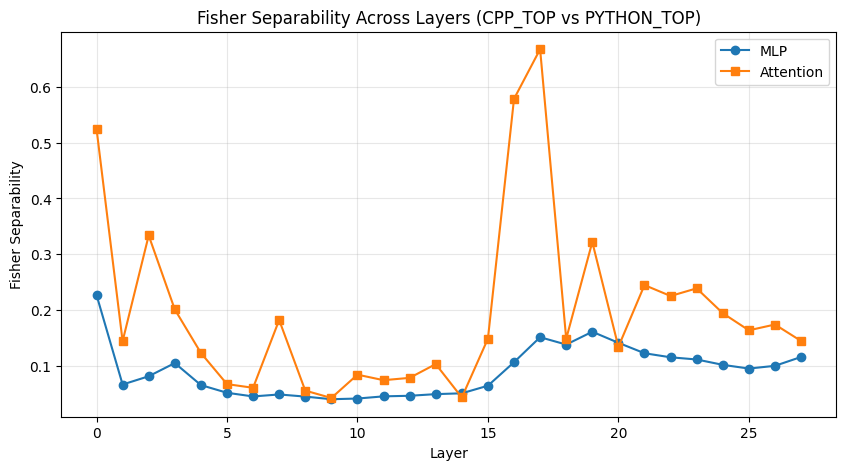

Ranking acc to attn:  [5, 7, 6, 2, 8, 0, 1, 23, 21, 11, 10, 27, 3, 26, 9, 12, 22, 25, 13, 24, 4, 18, 17, 15, 16, 14, 19, 20]
Ranking acc to mlp:  [12, 27, 9, 11, 13, 8, 15, 14, 7, 10, 16, 6, 17, 18, 0, 5, 19, 3, 26, 20, 4, 21, 25, 2, 23, 22, 24, 1]


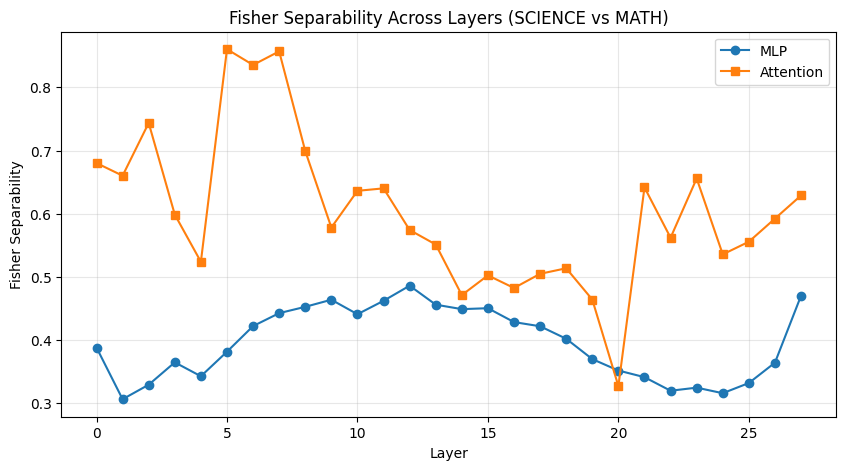

Ranking acc to attn:  [0, 27, 2, 1, 17, 5, 4, 15, 25, 7, 10, 20, 16, 9, 6, 12, 13, 3, 11, 23, 26, 8, 24, 14, 22, 19, 21, 18]
Ranking acc to mlp:  [27, 26, 16, 17, 18, 15, 19, 25, 20, 14, 12, 21, 13, 9, 10, 0, 22, 23, 24, 7, 11, 4, 8, 3, 6, 5, 2, 1]


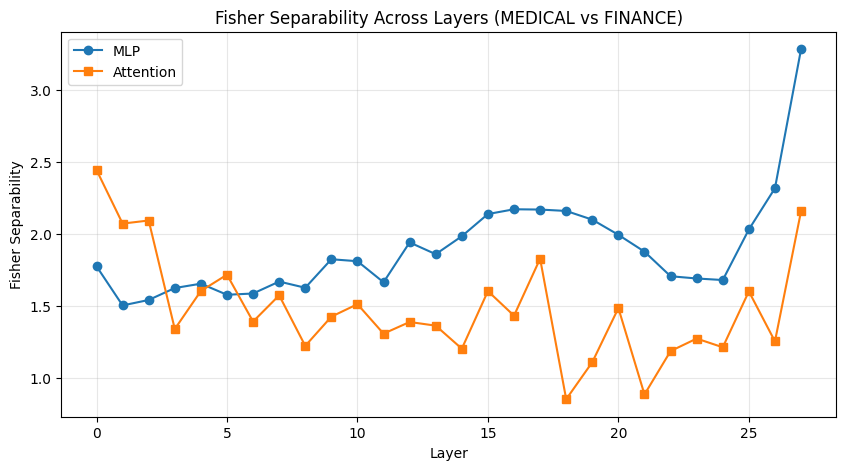

In [11]:
# What Fisher scores look like 

with open("scores/llama_3b_scores.json", 'r') as f:
    data = json.load(f)

def display(dataset_1, dataset_2, metric="fisher_separability"):
    mlp_data = data[f"mlp_{dataset_1}_vs_{dataset_2}_{metric}"]
    attn_data = data[f"attn_{dataset_1}_vs_{dataset_2}_{metric}"]
    attn_layer_ranks = sorted(range(len(attn_data)), key=lambda i: attn_data[i], reverse=True)
    print("Ranking acc to attn: ", attn_layer_ranks)
    mlp_layer_ranks = sorted(range(len(mlp_data)), key=lambda i: mlp_data[i], reverse=True)
    print("Ranking acc to mlp: ", mlp_layer_ranks)
    plt.figure(figsize=(10,5))
    plt.plot(mlp_data, label="MLP", marker="o")
    plt.plot(attn_data, label="Attention", marker="s")
    plt.xlabel("Layer")
    plt.ylabel("Fisher Separability")
    plt.title(f"Fisher Separability Across Layers ({dataset_1.upper()} vs {dataset_2.upper()})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
display("cpp_top", "python_top")
display("science", "math")
display("medical", "finance")
def layer_rank(dataset_1, dataset_2, metric="fisher_separability", descending=True):
    mlp_data = data[f"mlp_{dataset_1}_vs_{dataset_2}_{metric}"]
    attn_data = data[f"attn_{dataset_1}_vs_{dataset_2}_{metric}"]
    attn_layer_ranks = sorted(range(len(attn_data)), key=lambda i: attn_data[i], reverse=descending)
    print("Ranking acc to attn: ", attn_layer_ranks)
    mlp_layer_ranks = sorted(range(len(mlp_data)), key=lambda i: mlp_data[i], reverse=descending)
    print("Ranking acc to mlp: ", mlp_layer_ranks)
    return attn_layer_ranks, mlp_layer_ranks



In [ ]:
def inspect_layers(model_dict, config, block_type, layers, test_name=""):
    LAYERS = []
    for index in layers:
        LAYERS.append(LayerSpec(block_type, index))
    crosswap_results = run_cross_swap_batch(model_dict, config, LAYERS)
    # print(crosswap_results)
    return crosswap_results


def layer_rank(dataset_1: str, dataset_2: str, data: dict, metric="fisher_separability", descending=True):
    """
    Ranks layers based on a given metric from the data dictionary.
    
    Args:
        dataset_1: Name of the first dataset.
        dataset_2: Name of the second dataset.
        data: The dictionary containing the pre-computed metric scores.
        metric: The metric to use for ranking.
        descending: If True, higher scores are better.
        
    Returns:
        A tuple of (attn_layer_ranks, mlp_layer_ranks).
    """
    # Construct the keys to access the metric data

    mlp_key = f"mlp_{dataset_1}_vs_{dataset_2}_{metric}"
    attn_key = f"attn_{dataset_1}_vs_{dataset_2}_{metric}"
    
    # Check if data exists
    if mlp_key not in data or attn_key not in data:
        raise KeyError(f"Metric data for '{mlp_key}' or '{attn_key}' not found in data dictionary.")

    mlp_data = data[mlp_key]
    attn_data = data[attn_key]
    
    # Sort layer indices based on their corresponding metric value
    attn_layer_ranks = sorted(range(1, len(attn_data)), key=lambda i: attn_data[i], reverse=descending)
    mlp_layer_ranks = sorted(range(1, len(mlp_data)), key=lambda i: mlp_data[i], reverse=descending)
    
    print(f"Ranking for {dataset_1} vs {dataset_2} (metric: {metric}):")
    print(f"  - ATTN ranks: {attn_layer_ranks}")
    print(f"  - MLP ranks:  {mlp_layer_ranks}\n")
    
    return attn_layer_ranks, mlp_layer_ranks

def run_top_bottom_layer_analysis(model_dict, config_dict: dict, metric="fisher_separability"):
    """
    Finds top/bottom 5 layers for each config, runs inspection, and returns results.

    Args:
        config_dict: A dictionary where keys are experiment names and values are config objects.
                     Each config object must have 'a.name' and 'b.name' attributes.
        data: The dictionary containing the pre-computed metric scores for ranking.
        metric: The metric to use for ranking layers.

    Returns:
        A nested dictionary containing the results from `inspect_layers` for each
        group (top_5_attn, bottom_5_attn, etc.) for each configuration.
    """
    with open(model_dict["data_path"], 'r') as f:
        data = json.load(f)
    all_results = {}

    for config_name, config in config_dict.items():
        print(f"--- Processing configuration: {config_name} ---")
        all_results[config_name] = {}
        
        # Step 1: Get the fully ranked layers for the current config
        d1 = config.a.name
        d2 = config.b.name
        attn_ranks, mlp_ranks = layer_rank(d1, d2, data, metric=metric)
        
        # Step 2: Get the top 5 and bottom 5 layers for both ATTN and MLP
        # Slicing handles cases where there are fewer than 10 layers
        layer_groups = {
            "top_5_attn": attn_ranks[:5],
            "bottom_5_attn": attn_ranks[-5:],
            "top_5_mlp": mlp_ranks[:5],
            "bottom_5_mlp": mlp_ranks[-5:]
        }
        
        # Step 3: Loop through the 4 groups and run the inspection function
        for group_name, layers in layer_groups.items():
            if not layers:
                print(f"Skipping '{group_name}' for '{config_name}' as no layers were found.")
                continue

            print(f"Running inspection for '{group_name}' with layers: {layers}")
            
            block_type = "attn" if "attn" in group_name else "mlp"
            
            # Call the provided inspection function
            
            group_results = inspect_layers(
                model_dict=model_dict,
                config=config,
                block_type=block_type,
                layers=layers,
                test_name=group_name
            )
            # print(f"Results for {config_name} and {group_name}")
            # print(group_results)
            
            all_results[config_name][group_name] = group_results
            
    print("\n--- Analysis Complete ---")
    return all_results

In [ ]:
def plot_block_type_results(experiment_data, block_type, side_names, main_title, model_name):
    """
    Generates grouped bar charts for a specific block type (attn or mlp).

    Args:
        experiment_data (dict): The dictionary for one experiment (e.g., data['cpp-python']).
        block_type (str): The type of block to plot ('attn' or 'mlp').
        side_names (tuple): Tuple of the two side names (e.g., ('cpp', 'python')).
        main_title (str): The overall title for the figure.
    """
    side_a_name, side_b_name = side_names

    # Filter data to only include categories for the specified block_type
    filtered_data = {
        key: value
        for key, value in experiment_data.items()
        if block_type in key
    }
    
    if not filtered_data:
        print(f"No data found for block type '{block_type}' in the provided experiment.")
        return

    # Create a figure with two subplots: one for KL, one for shift_other
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(main_title, fontsize=18)

    axes = {'KL': ax1, 'shift_other': ax2}
    
    for metric, ax in axes.items():
        all_labels = []
        all_means_a = []
        all_stds_a = []
        all_means_b = []
        all_stds_b = []
        
        # Iterate through the filtered categories (e.g., top_5_attn, bottom_5_attn)
        for category_name, layers_data in filtered_data.items():
            layer_names = list(layers_data.keys())
            all_labels.extend(layer_names)
            
            all_means_a.extend([layers_data[layer][side_a_name][metric]['mean'] for layer in layer_names])
            all_stds_a.extend([layers_data[layer][side_a_name][metric]['std'] for layer in layer_names])
            all_means_b.extend([layers_data[layer][side_b_name][metric]['mean'] for layer in layer_names])
            all_stds_b.extend([layers_data[layer][side_b_name][metric]['std'] for layer in layer_names])

        # Plotting logic
        x = np.arange(len(all_labels))
        width = 0.35

        ax.bar(x - width/2, all_means_a, width, label=side_a_name.upper(), yerr=all_stds_a, capsize=5, alpha=0.8)
        ax.bar(x + width/2, all_means_b, width, label=side_b_name.upper(), yerr=all_stds_b, capsize=5, alpha=0.8)

        # Add text, labels, and title
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'Comparison of {metric} Metric', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(all_labels, rotation=45, ha="right", fontsize=10)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add a single vertical line between the 'top_5' and 'bottom_5' categories
        if len(filtered_data) > 1:
            # The line should be after the first group of bars
            separator_pos = len(list(filtered_data.values())[0]) - 0.5
            ax.axvline(separator_pos, color='grey', linestyle='--')
    save_dir = f"cvp_results_imgs/{model_name}"
    os.makedirs(save_dir, exist_ok=True) 
    plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
    plt.savefig(f"{save_dir}/{block_type}_{side_names[0]}_{side_names[1]}.png", dpi=300, bbox_inches="tight")
    plt.show()


# with open("cvp-2-results2.json", 'r') as f:
#     shift_data = json.load(f)
    

In [ ]:

def run_kl_analysis(model_dict, config_dict, metric="fisher_separability"):

    with open(model_dict["data_path"], 'r') as f:
        data = json.load(f)
    all_results = {}

    for config_name, config in config_dict.items():
        print(f"--- Processing configuration: {config_name} ---")
        all_results[config_name] = {}
        
        # Step 1: Get the fully ranked layers for the current config
        d1 = config.a.name
        d2 = config.b.name
        attn_ranks, mlp_ranks = layer_rank(d1, d2, data, metric=metric)
        
        # Step 2: Get the top 5 and bottom 5 layers for both ATTN and MLP
        # Slicing handles cases where there are fewer than 10 layers
        layer_groups = {
            "top_5_attn": attn_ranks[:5],
            "bottom_5_attn": attn_ranks[-5:],
            "top_5_mlp": mlp_ranks[:5],
            "bottom_5_mlp": mlp_ranks[-5:]
        }
        
        # Step 3: Loop through the 4 groups and run the inspection function
        for group_name, layers in layer_groups.items():
            if not layers:
                print(f"Skipping '{group_name}' for '{config_name}' as no layers were found.")
                continue

            print(f"Running inspection for '{group_name}' with layers: {layers}")
            
            block_type = "attn" if "attn" in group_name else "mlp"
            
            # Call the provided inspection function
            
            group_results = inspect_layers(
                model_dict=model_dict,
                config=config,
                block_type=block_type,
                layers=layers,
                test_name=group_name
            )
            # print(f"Results for {config_name} and {group_name}")
            # print(group_results)
            
            all_results[config_name][group_name] = group_results
            
    print("\n--- Analysis Complete ---")
    return all_results
def compute_kl(model_path, model_name, config_dict):
    """
    Loads a model, runs analysis, unloads it to free GPU memory,
    and then processes the results.
    """

    results = None
    model = None
    tokenizer = None
    model_dict = None

    try:
        # =================================================================
        # PART 1: LOAD MODEL AND RUN ANALYSIS (GPU HEAVY)
        # =================================================================
        print(f"--- Starting analysis for {model_name} ---")
        memory_before = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated before load: {memory_before:.2f} GB")
        if "gemma_4b" in model_name.lower():
            DTYPE = torch.bfloat16
        else:
            DTYPE = torch.float16
        tokenizer = AutoTokenizer.from_pretrained(model_path, token=HF_TOKEN, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_path, token=HF_TOKEN, torch_dtype=DTYPE, low_cpu_mem_usage=True
        ).to(DEVICE).eval()

        memory_after = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated after load:  {memory_after:.2f} GB")

        # Simplified logic to get the number of layers
        if "gemma_4b" in model_name.lower():
            num_layers = len(model.model.language_model.layers)
        else:  # Assuming Llama-like structure
            num_layers = len(model.model.layers)

        model_dict = {
            "model": model,
            "tokenizer": tokenizer,
            "layers": num_layers,
            "data_path": f"scores/{model_name}_scores.json"
        }

        # This is where all the GPU computation should happen
        results = run_kl_analysis(model_dict, config_dict)
        print("Analysis complete.")

    finally:
        # =================================================================
        # PART 2: UNLOAD MODEL AND CLEAR GPU MEMORY
        # =================================================================
        print("\nUnloading model and clearing GPU memory...")
        
        # Explicitly delete all large objects that have references to the model
        del model_dict
        del model
        del tokenizer
        
        # Force garbage collection and empty CUDA cache
        gc.collect()
        torch.cuda.empty_cache()

        memory_final = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated after unload: {memory_final:.2f} GB")
        print("--- GPU intensive tasks finished ---")
        # 1. Define the directory name you want
        save_dir = "full_compute"
        os.makedirs(save_dir, exist_ok=True) 
        filepath = os.path.join(save_dir, f"{model_name}.json")
        with open(filepath, "w") as f:
            json.dump(results, f)
            
def run_model_analysis_and_unload(model_path, model_name, config_dict):
    """
    Loads a model, runs analysis, unloads it to free GPU memory,
    and then processes the results.
    """
    results = None
    model = None
    tokenizer = None
    model_dict = None

    try:
        # =================================================================
        # PART 1: LOAD MODEL AND RUN ANALYSIS (GPU HEAVY)
        # =================================================================
        print(f"--- Starting analysis for {model_name} ---")
        memory_before = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated before load: {memory_before:.2f} GB")
        if "gemma_4b" in model_name.lower():
            DTYPE = torch.bfloat16
        else:
            DTYPE = torch.float16
        tokenizer = AutoTokenizer.from_pretrained(model_path, token=HF_TOKEN, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_path, token=HF_TOKEN, torch_dtype=DTYPE, low_cpu_mem_usage=True
        ).to(DEVICE).eval()

        memory_after = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated after load:  {memory_after:.2f} GB")

        # Simplified logic to get the number of layers
        if "gemma_4b" in model_name.lower():
            num_layers = len(model.model.language_model.layers)
        else:  # Assuming Llama-like structure
            num_layers = len(model.model.layers)

        model_dict = {
            "model": model,
            "tokenizer": tokenizer,
            "layers": num_layers,
            "data_path": f"scores/{model_name}_scores.json"
        }

        # This is where all the GPU computation should happen
        results = run_top_bottom_layer_analysis(model_dict, config_dict)
        print("Analysis complete.")

    finally:
        # =================================================================
        # PART 2: UNLOAD MODEL AND CLEAR GPU MEMORY
        # =================================================================
        print("\nUnloading model and clearing GPU memory...")
        
        # Explicitly delete all large objects that have references to the model
        del model_dict
        del model
        del tokenizer
        
        # Force garbage collection and empty CUDA cache
        gc.collect()
        torch.cuda.empty_cache()

        memory_final = torch.cuda.memory_allocated(DEVICE) / 1024**3
        print(f"GPU memory allocated after unload: {memory_final:.2f} GB")
        print("--- GPU intensive tasks finished ---")

    # =================================================================
    # PART 3: PROCESS RESULTS (CPU & DISK HEAVY)
    # =================================================================
    # This part only runs after the model is confirmed to be off the GPU.
    if results is not None:
        print("\nProcessing and saving results...")
        save_dir = "model_cvp_results"
        os.makedirs(save_dir, exist_ok=True)
        
        results_path = f"{save_dir}/{model_name}.json"
        with open(results_path, 'w') as f:
            json.dump(results, f)

        with open(results_path, 'r') as f:
            shift_data = json.load(f)

        plot_block_type_results(
            experiment_data=shift_data['cpp-python'],
            block_type='mlp',
            side_names=('cpp_top', 'python_top'),
            main_title='Analysis of C++ vs. Python Data',
            model_name=model_name
        )
        plot_block_type_results(
            experiment_data=shift_data['cpp-python'],
            block_type='attn',
            side_names=('cpp_top', 'python_top'),
            main_title='Analysis of C++ vs. Python Data',
            model_name=model_name
        )
        print("Result processing and plotting complete.")
    else:
        print("No results were generated, skipping post-processing.")

    
    
    
    

In [ ]:
model_path = "google/gemma-3-4b-it"
model_name = "gemma_4b"
compute_kl(model_path, model_name, config_dict)

In [ ]:
model_path = "meta-llama/Llama-3.2-3B"
model_name = "llama_3b"
compute_kl(model_path, model_name, config_dict)

In [ ]:
model_path = "google/gemma-3-1b-it"
model_name = "gemma_1b"
compute_kl(model_path, model_name, config_dict)

In [ ]:
model_path = "meta-llama/Llama-3.2-1B"
model_name = "llama_1b"
compute_kl(model_path, model_name, config_dict)